In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import tensorflow as tf


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv2D, GlobalMaxPooling2D, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from keras.utils import np_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder



Using TensorFlow backend.


In [3]:
challenge_data = pd.read_csv('drive/My Drive/Colab Notebooks/Recommender Systems/JanataHack/challenge_data.csv')
train = pd.read_csv('drive/My Drive/Colab Notebooks/Recommender Systems/JanataHack/train.csv')
test = pd.read_csv('drive/My Drive/Colab Notebooks/Recommender Systems/JanataHack/test.csv')
sub = pd.read_csv('drive/My Drive/Colab Notebooks/Recommender Systems/JanataHack/sample_submission.csv')


In [4]:
train.head(13)

,user_sequence,user_id,challenge_sequence,challenge
0,4576_1,4576,1,CI23714
1,4576_2,4576,2,CI23855
2,4576_3,4576,3,CI24917
3,4576_4,4576,4,CI23663
4,4576_5,4576,5,CI23933
5,4576_6,4576,6,CI25135
6,4576_7,4576,7,CI23975
7,4576_8,4576,8,CI25126
8,4576_9,4576,9,CI24915
9,4576_10,4576,10,CI24957


In [5]:
train.drop('user_sequence', axis=1, inplace=True)
test.drop('user_sequence', axis=1, inplace=True)

In [6]:
train

,user_id,challenge_sequence,challenge
0,4576,1,CI23714
1,4576,2,CI23855
2,4576,3,CI24917
3,4576,4,CI23663
4,4576,5,CI23933
...,...,...,...
903911,113839,9,CI24992
903912,113839,10,CI28586
903913,113839,11,CI28610
903914,113839,12,CI26388


In [7]:
concat_train = train.groupby("user_id").agg({"challenge": lambda x: ' '.join(set(x.dropna()))})

In [8]:
list(concat_train.iloc[0])

['CI23933 CI25126 CI24915 CI23975 CI23667 CI23691 CI24958 CI24957 CI25135 CI23855 CI23714 CI23663 CI24917']

In [9]:
concat_train.shape

(69532, 1)

In [10]:
concat_train.head()

,challenge
user_id,
4576,CI23933 CI25126 CI24915 CI23975 CI23667 CI2369...
4580,CI23933 CI25727 CI23648 CI24915 CI23975 CI2371...
4581,CI26158 CI26163 CI26159 CI26164 CI26166 CI2615...
4582,CI23933 CI24915 CI23975 CI23714 CI26051 CI2495...
4585,CI23933 CI25126 CI24915 CI23975 CI24958 CI2384...


In [11]:
concat_train = concat_train.reset_index(drop=True)

In [12]:
concat_train.head()

,challenge
0,CI23933 CI25126 CI24915 CI23975 CI23667 CI2369...
1,CI23933 CI25727 CI23648 CI24915 CI23975 CI2371...
2,CI26158 CI26163 CI26159 CI26164 CI26166 CI2615...
3,CI23933 CI24915 CI23975 CI23714 CI26051 CI2495...
4,CI23933 CI25126 CI24915 CI23975 CI24958 CI2384...


In [13]:
concat_train['challenge']

0        CI23933 CI25126 CI24915 CI23975 CI23667 CI2369...
1        CI23933 CI25727 CI23648 CI24915 CI23975 CI2371...
2        CI26158 CI26163 CI26159 CI26164 CI26166 CI2615...
3        CI23933 CI24915 CI23975 CI23714 CI26051 CI2495...
4        CI23933 CI25126 CI24915 CI23975 CI24958 CI2384...
                               ...                        
69527    CI23933 CI24521 CI24876 CI24438 CI24445 CI2443...
69528    CI25258 CI23933 CI25023 CI25022 CI24866 CI2502...
69529    CI25053 CI24230 CI26920 CI26051 CI23999 CI2495...
69530    CI26052 CI23880 CI25049 CI23933 CI24876 CI2399...
69531    CI28586 CI25727 CI28610 CI28328 CI24954 CI2491...
Name: challenge, Length: 69532, dtype: object

In [14]:
outF = open('concat_train.txt', 'w')
for i in concat_train['challenge'].values:
  outF.write(i)
  outF.write('\n')
outF.close()

In [15]:
tokenizer = Tokenizer()

data = open('concat_train.txt').read()

corpus = data.lower().split('\n')

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'ci23855': 1, 'ci23714': 2, 'ci24917': 3, 'ci23663': 4, 'ci24958': 5, 'ci23933': 6, 'ci25135': 7, 'ci24530': 8, 'ci23691': 9, 'ci23848': 10, 'ci25126': 11, 'ci24876': 12, 'ci23769': 13, 'ci24915': 14, 'ci24527': 15, 'ci25075': 16, 'ci24534': 17, 'ci23975': 18, 'ci23648': 19, 'ci25141': 20, 'ci24187': 21, 'ci24138': 22, 'ci25124': 23, 'ci24228': 24, 'ci24968': 25, 'ci24866': 26, 'ci26925': 27, 'ci23913': 28, 'ci24261': 29, 'ci24953': 30, 'ci25142': 31, 'ci24532': 32, 'ci24868': 33, 'ci26051': 34, 'ci24957': 35, 'ci26910': 36, 'ci23667': 37, 'ci24875': 38, 'ci26915': 39, 'ci26930': 40, 'ci26923': 41, 'ci25074': 42, 'ci25125': 43, 'ci24531': 44, 'ci26221': 45, 'ci24440': 46, 'ci25140': 47, 'ci24418': 48, 'ci26916': 49, 'ci26902': 50, 'ci26220': 51, 'ci23880': 52, 'ci26931': 53, 'ci23887': 54, 'ci23856': 55, 'ci25057': 56, 'ci26219': 57, 'ci26052': 58, 'ci26217': 59, 'ci23770': 60, 'ci26903': 61, 'ci24031': 62, 'ci26927': 63, 'ci26918': 64, 'ci25056': 65, 'ci26922': 66, 'ci24230': 67, 'ci

In [16]:
input_sequences_x = []
input_sequences = []
input_y = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(10, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

In [17]:
input_sequences[:10]

[[6, 11, 14, 18, 37, 9, 5, 35, 7, 1, 2],
 [6, 11, 14, 18, 37, 9, 5, 35, 7, 1, 2, 4],
 [6, 11, 14, 18, 37, 9, 5, 35, 7, 1, 2, 4, 3],
 [6, 104, 19, 14, 18, 2, 100, 37, 34, 7, 1],
 [6, 104, 19, 14, 18, 2, 100, 37, 34, 7, 1, 4],
 [6, 104, 19, 14, 18, 2, 100, 37, 34, 7, 1, 4, 8],
 [261, 354, 251, 191, 259, 281, 219, 315, 222, 192, 212],
 [261, 354, 251, 191, 259, 281, 219, 315, 222, 192, 212, 297],
 [261, 354, 251, 191, 259, 281, 219, 315, 222, 192, 212, 297, 249],
 [6, 14, 18, 2, 34, 5, 116, 35, 30, 7, 1]]

In [18]:
type(input_sequences), type(input_sequences[0])

(list, list)

In [19]:
# pad sequences
max_sequences_len = 13
input_sequences = pad_sequences(input_sequences, maxlen=max_sequences_len, padding='pre')
#input_y = np.array(input_y)
input_sequences_x = input_sequences[:,:-1]
input_y = input_sequences[:,-1:]

In [20]:
input_sequences_x[:10]

array([[  0,   0,   6,  11,  14,  18,  37,   9,   5,  35,   7,   1],
       [  0,   6,  11,  14,  18,  37,   9,   5,  35,   7,   1,   2],
       [  6,  11,  14,  18,  37,   9,   5,  35,   7,   1,   2,   4],
       [  0,   0,   6, 104,  19,  14,  18,   2, 100,  37,  34,   7],
       [  0,   6, 104,  19,  14,  18,   2, 100,  37,  34,   7,   1],
       [  6, 104,  19,  14,  18,   2, 100,  37,  34,   7,   1,   4],
       [  0,   0, 261, 354, 251, 191, 259, 281, 219, 315, 222, 192],
       [  0, 261, 354, 251, 191, 259, 281, 219, 315, 222, 192, 212],
       [261, 354, 251, 191, 259, 281, 219, 315, 222, 192, 212, 297],
       [  0,   0,   6,  14,  18,   2,  34,   5, 116,  35,  30,   7]],
      dtype=int32)

In [21]:
type(input_sequences_x), type(input_sequences_x[0]), input_sequences_x.shape

(numpy.ndarray, numpy.ndarray, (208596, 12))

In [22]:
input_y[:10] 

array([[  2],
       [  4],
       [  3],
       [  1],
       [  4],
       [  8],
       [212],
       [297],
       [249],
       [  1]], dtype=int32)

In [23]:
type(input_y), type(input_y[0])

(numpy.ndarray, numpy.ndarray)

In [24]:
#input_y =  np.array([np.array(i, dtype='object') for i in input_y], dtype='object')

In [25]:
type(input_y), type(input_y[0]), (input_y.shape)

(numpy.ndarray, numpy.ndarray, (208596, 1))

In [26]:
#xs = tf.keras.utils.to_categorical(input_sequences_x, num_classes=total_words, dtype='int8')
ys = tf.keras.utils.to_categorical(input_y, num_classes=total_words, dtype='int8')

In [27]:
ys.shape

(208596, 5349)

In [28]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=10))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           534900    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 2674)              270074    
_________________________________________________________________
dense_1 (Dense)              (None, 5349)              14308575  
Total params: 15,575,149
Trainable params: 15,575,149
Non-trainable params: 0
____________________________________________

In [29]:
 history = model.fit(input_sequences_x, ys, epochs=10, verbose=1)

Epoch 1/10
6519/6519 [==============================] - 101s 15ms/step - loss: 3.8908 - accuracy: 0.2053
Epoch 2/10
6519/6519 [==============================] - 101s 15ms/step - loss: 3.0458 - accuracy: 0.3093
Epoch 3/10
6519/6519 [==============================] - 101s 15ms/step - loss: 2.8041 - accuracy: 0.3471
Epoch 4/10
6519/6519 [==============================] - 101s 15ms/step - loss: 2.6439 - accuracy: 0.3743
Epoch 5/10
6519/6519 [==============================] - 101s 16ms/step - loss: 2.5230 - accuracy: 0.3944
Epoch 6/10
6519/6519 [==============================] - 100s 15ms/step - loss: 2.4216 - accuracy: 0.4128
Epoch 7/10
6519/6519 [==============================] - 101s 15ms/step - loss: 2.3313 - accuracy: 0.4307
Epoch 8/10
6519/6519 [==============================] - 100s 15ms/step - loss: 2.2539 - accuracy: 0.4453
Epoch 9/10
6519/6519 [==============================] - 100s 15ms/step - loss: 2.1827 - accuracy: 0.4585
Epoch 10/10
6519/6519 [==============================] 

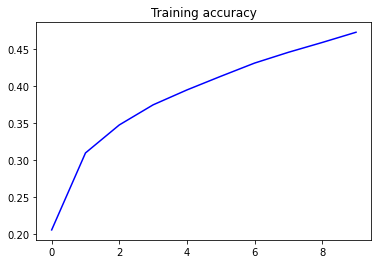

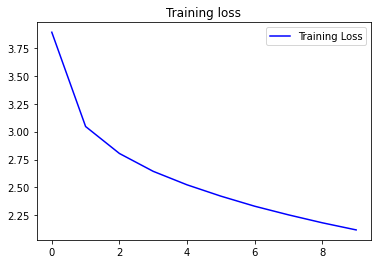

In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [32]:
model.save_weights("model.h5")

In [35]:
concat_test = test.groupby("user_id").agg({"challenge": lambda x: ' '.join(set(x.dropna()))})
concat_test = concat_test.reset_index(drop=True)
concat_test["challenge"][0]

'CI23933 CI25727 CI24915 CI24958 CI25135 CI23855 CI23714 CI24530 CI23663 CI24917'

In [37]:
def getop(seed_text,next_words):  
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=10, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word.upper()
  return seed_text.split(" ")[-3:]

In [39]:
%%time
op_list = []
for i in range(len(concat_test)):
  seed_text = concat_test["challenge"][i]
  next_words = 3
  op_list.append(getop(seed_text,next_words))

CPU times: user 49min 22s, sys: 1min 34s, total: 50min 57s
Wall time: 48min 43s


In [40]:
sub["challenge"] = np.array(op_list).reshape(-1,1)

In [41]:
sub

,user_sequence,challenge
0,4577_11,CI23663
1,4577_12,CI23856
2,4577_13,CI24968
3,4578_11,CI23663
4,4578_12,CI24522
...,...,...
119191,113834_12,CI25052
119192,113834_13,CI24917
119193,113838_11,CI23663
119194,113838_12,CI24868


In [42]:
sub.to_csv("submit.csv",index=False)